In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import random

In [2]:
def fill_with_mode(column = None):
    """
    Função para escolher a moda de uma série de dados.
    """
    fill_column = column.copy()
    modas = column.mode()
    if len(modas) == 1:
        fill_column = fill_column.fillna(modas[0])
        return fill_column
    
    fill_column = fill_column.fillna(random.choice(modas))
    return fill_column

In [3]:
def calculate_outliers(df = None):
    """
    Função para calcular os outliers de um dataframe.
    """
    if df is None:
        raise ValueError("O dataframe não pode ser None.")
    if not isinstance(df, pd.DataFrame):
        raise TypeError("O argumento df deve ser um dataframe do pandas.")
    
    numerical_columns = df.select_dtypes(include=['int','float']).columns.tolist()
    outliers = []

    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        mask = (df[column] < lower_limit) | (df[column] > upper_limit)
        qtd_outliers = mask.sum()
        percentage_outliers = (qtd_outliers / df[column].size) * 100
        outliers.append({
            'Column': column,
            'Qtd_outliers': qtd_outliers,
            'Percentage_outliers': percentage_outliers,
        })

    return pd.DataFrame(outliers)

In [4]:
train = pd.read_csv('../../dataset/train.csv')

In [5]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
train[['Age','SibSp','Fare','Parch']].describe()

,Age,SibSp,Fare,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,32.204208,0.381594
std,14.526497,1.102743,49.693429,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,31.000000,0.000000
max,80.000000,8.000000,512.329200,6.000000


In [7]:
sumario_vazios = pd.DataFrame({
    'Coluna': train.columns,
    'Quantidade': train.isnull().sum(axis=0).values,
    'Porcentagem': (train.isnull().mean() * 100).round(2).values
})
sumario_vazios

,Coluna,Quantidade,Porcentagem
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,177,19.87
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,0,0.00


In [8]:

# Lidando com valores nulos em 'Age', 'Cabin', 'Embarked'
train = train.dropna(subset=['Embarked'])
train['Age'] = train['Age'].fillna(int(train['Age'].median()))
train['Cabin'] = fill_with_mode(train['Cabin'])

In [9]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,C23 C25 C27,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,C23 C25 C27,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,C23 C25 C27,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,C23 C25 C27,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,C23 C25 C27,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
print(train['Age'].isna().sum())
print(train['Cabin'].isna().sum())
print(train['Embarked'].isna().sum())

0
0
0


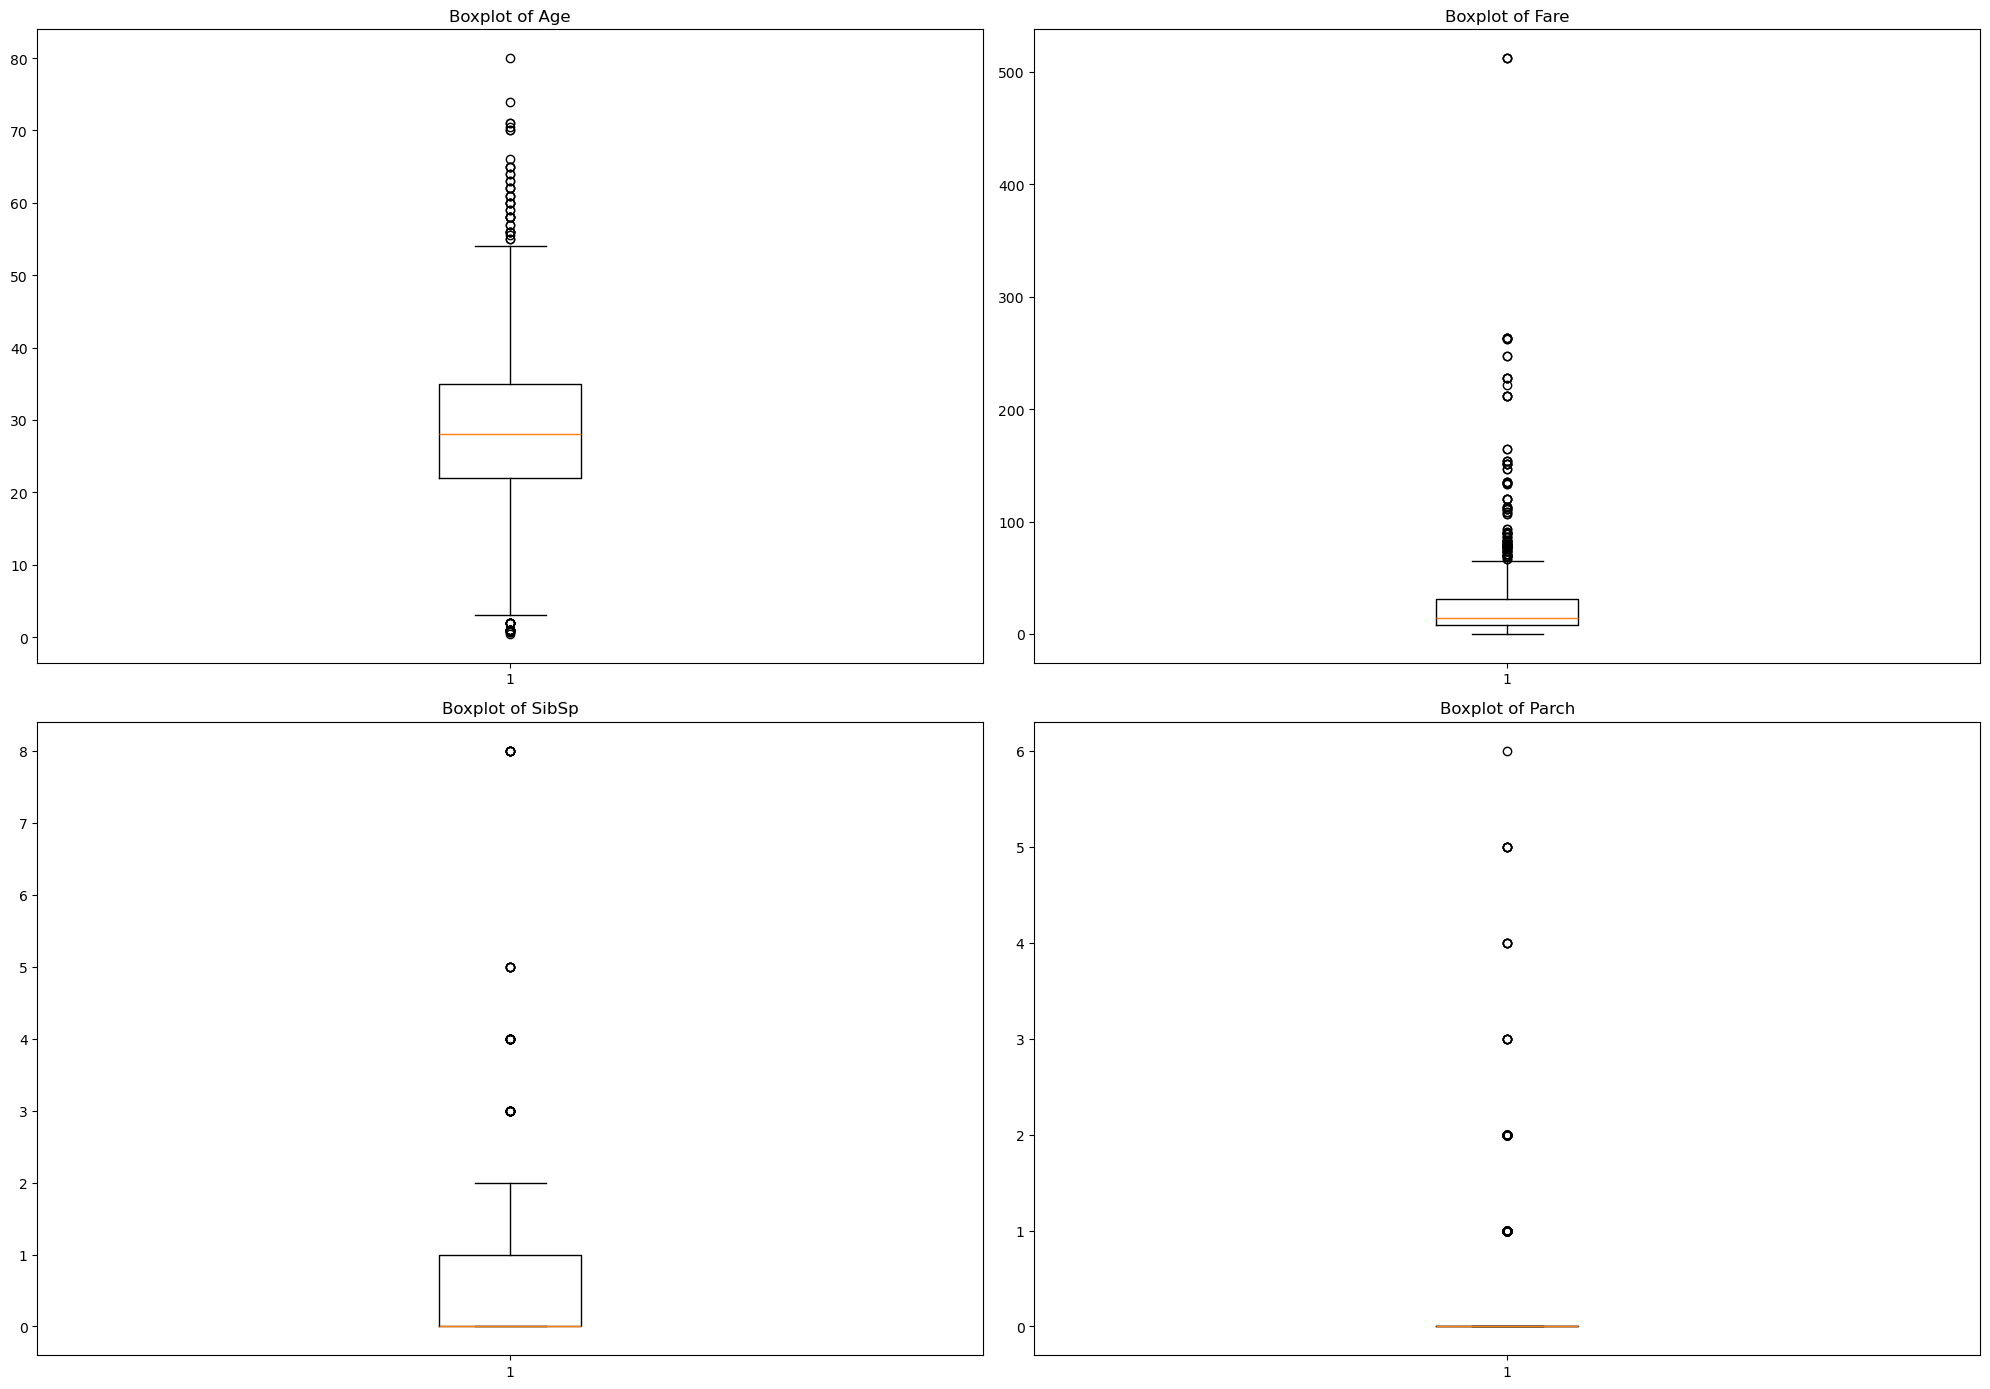

In [11]:
# Usando Boxplot para identificar outliers

fig, ax = plt.subplots(2,2,figsize=(20, 14))
ax[0,0].set_title('Boxplot of Age')
ax[0,0].boxplot(train['Age'])

ax[0,1].set_title('Boxplot of Fare')
ax[0,1].boxplot(x=train['Fare'])

ax[1,0].set_title('Boxplot of SibSp')
ax[1,0].boxplot(x=train['SibSp'])

ax[1,1].set_title('Boxplot of Parch')
ax[1,1].boxplot(x=train['Parch'])
plt.tight_layout()
plt.show()

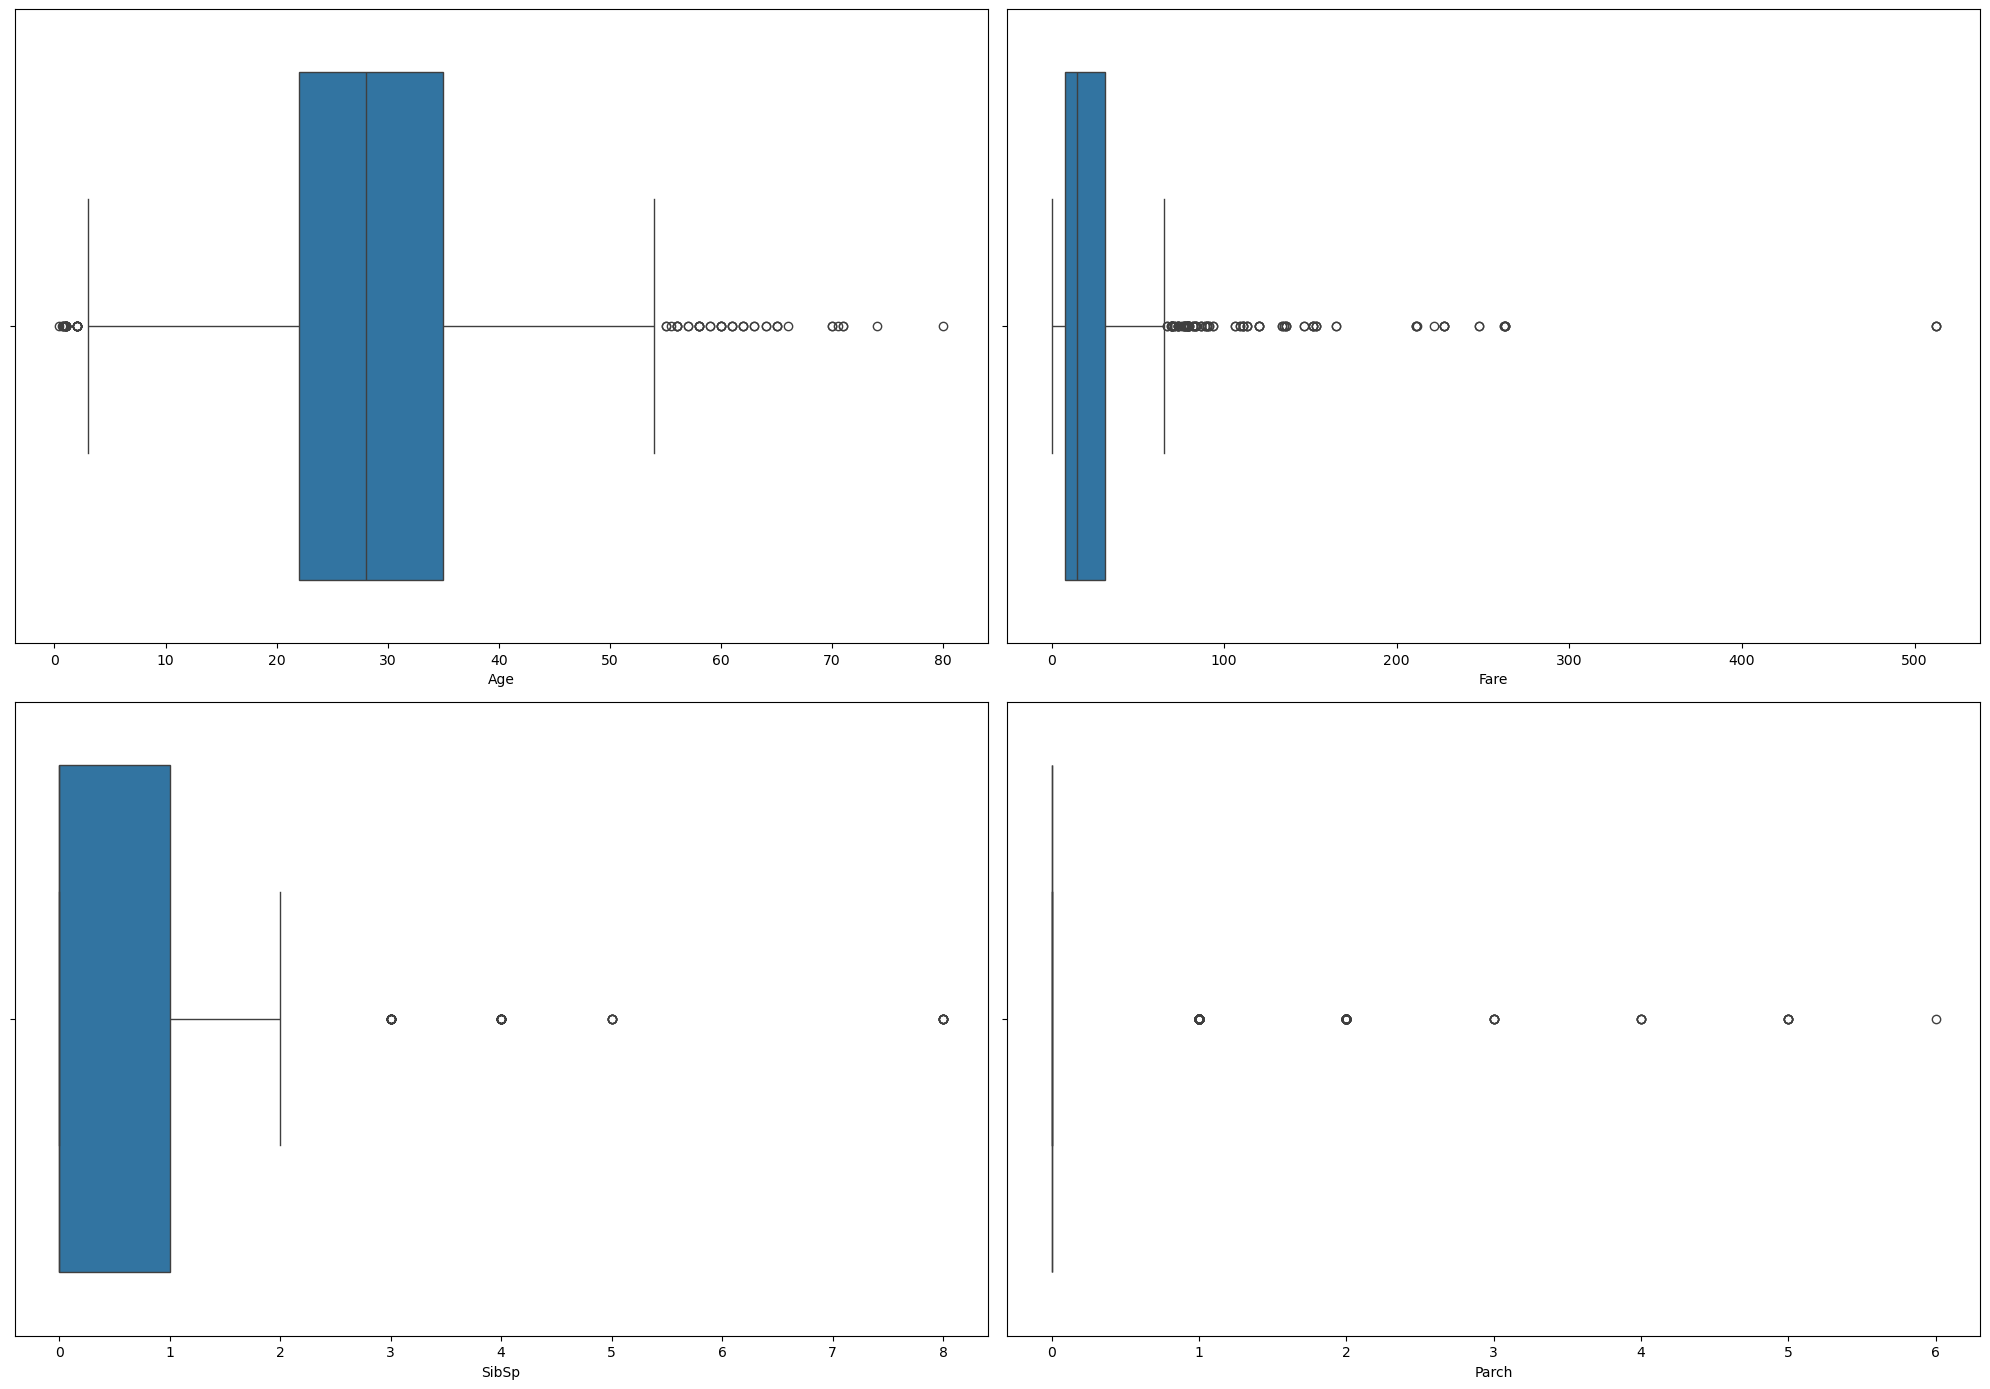

In [12]:
# Usando Seaborn para visualizar os outliers
fig, ax = plt.subplots(2,2,figsize=(20, 14))
sns.boxplot(x=train['Age'], ax=ax[0,0])
sns.boxplot(x=train['Fare'], ax=ax[0,1])
sns.boxplot(x=train['SibSp'], ax=ax[1,0])
sns.boxplot(x=train['Parch'], ax=ax[1,1])
plt.tight_layout()
plt.show()

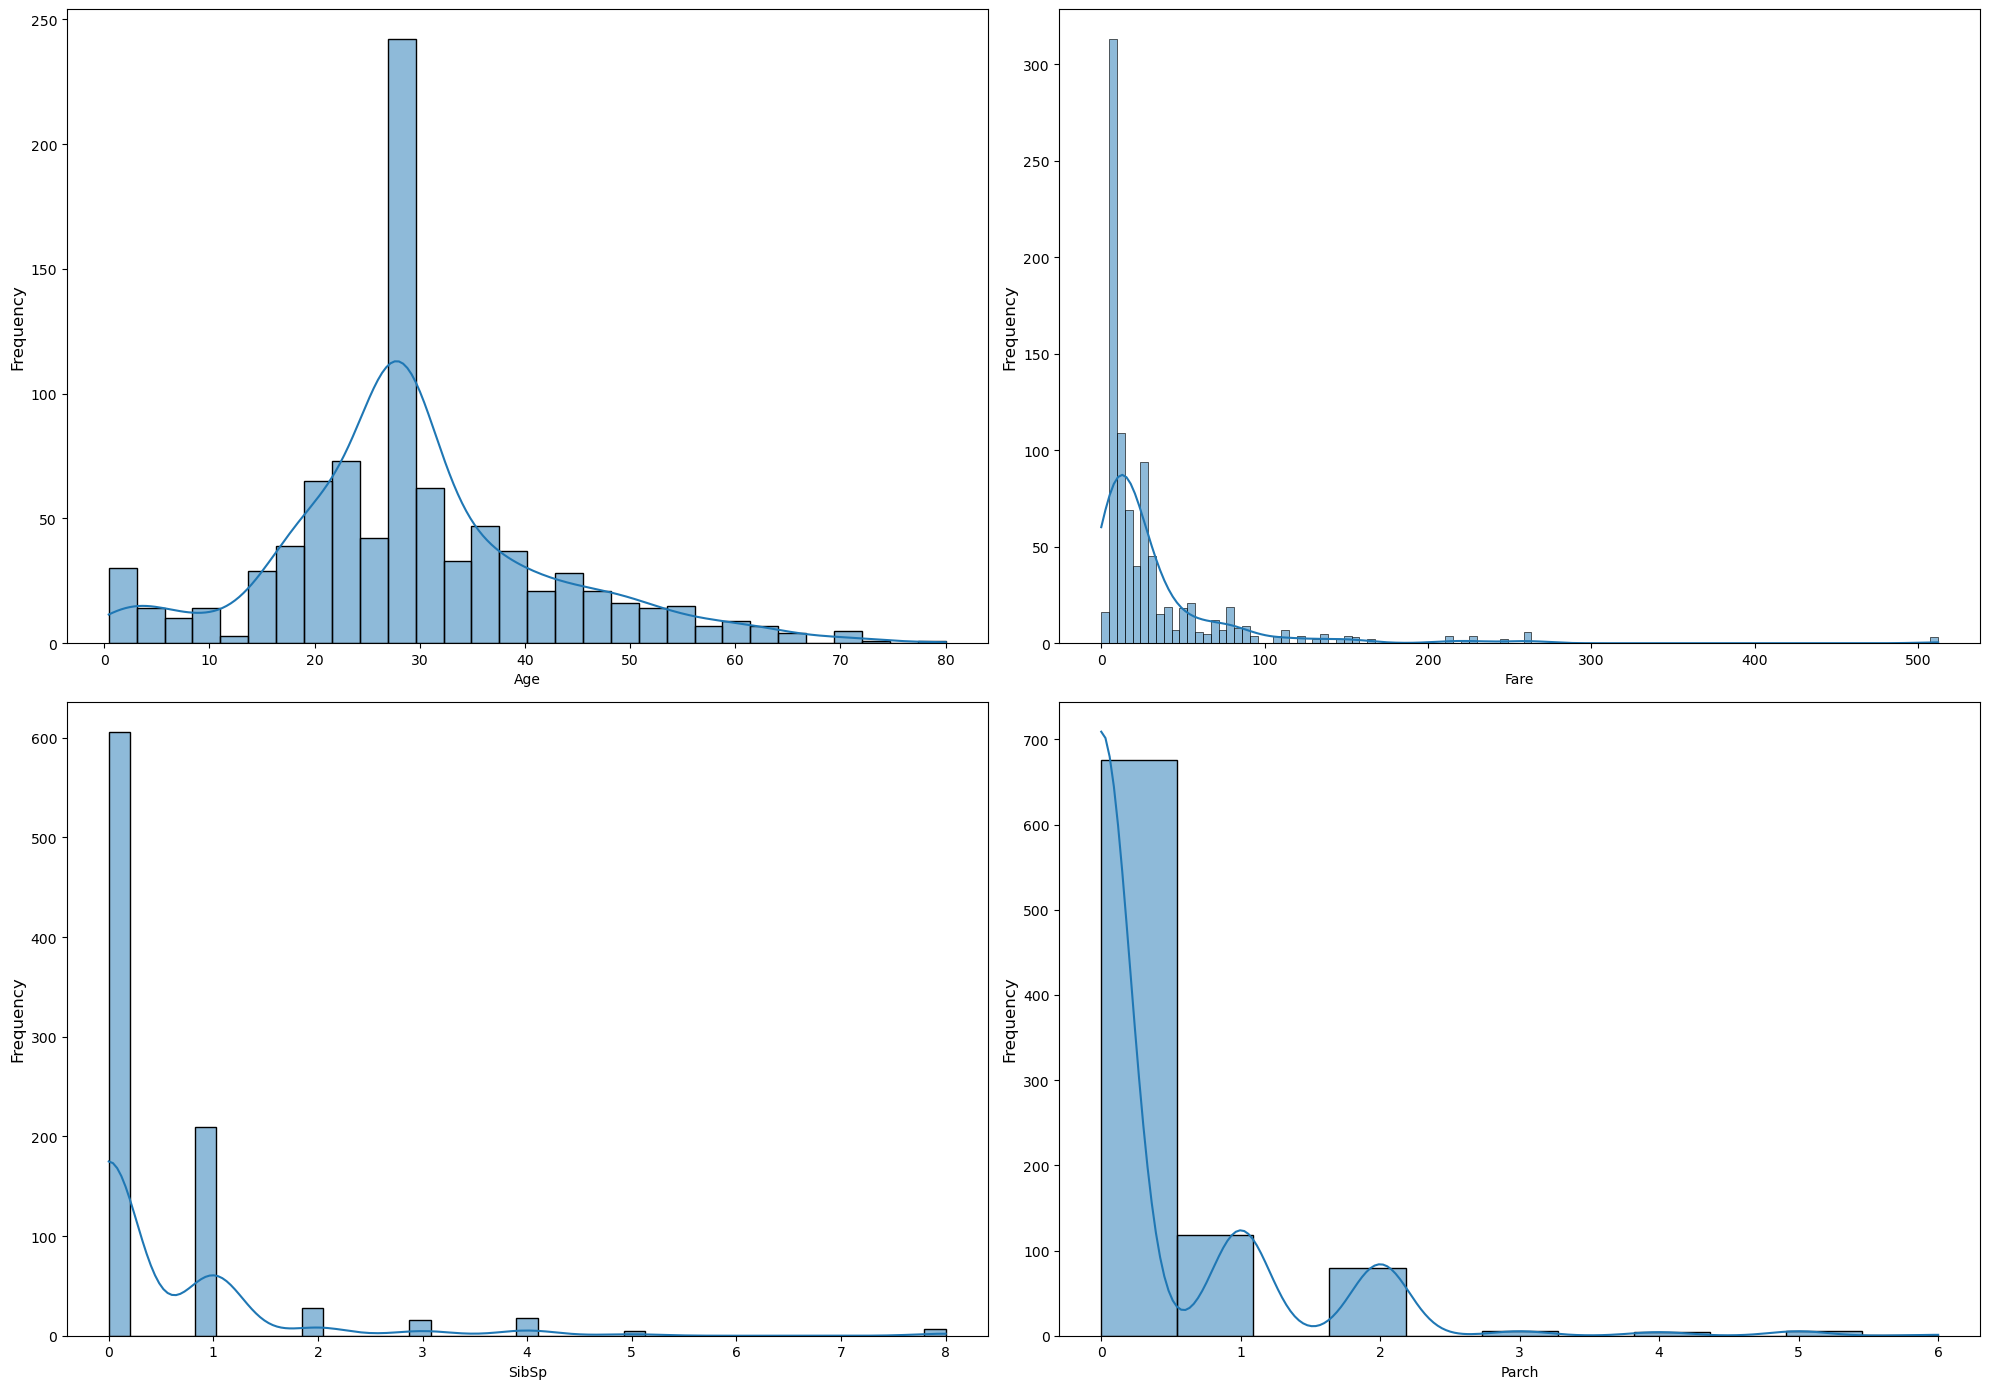

In [13]:
fig, ax = plt.subplots(2,2,figsize=(20, 14))
sns.histplot(train['Age'], ax=ax[0,0], kde=True)
sns.histplot(train['Fare'], ax=ax[0,1], kde=True)
sns.histplot(train['SibSp'], ax=ax[1,0], kde=True)
sns.histplot(train['Parch'], ax=ax[1,1], kde=True)

for axis in ax.flat:
    axis.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

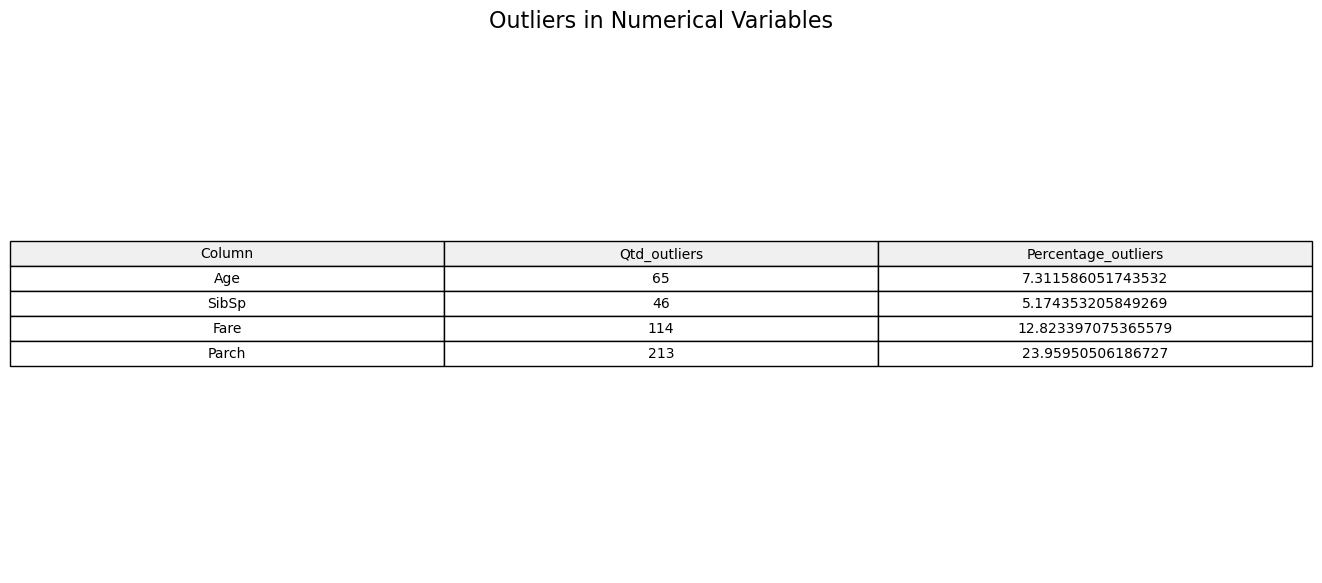

In [14]:
train_outliers = train[['Age','SibSp','Fare','Parch']]
train_outliers = calculate_outliers(train_outliers)

figure, ax = plt.subplots(figsize=(14, 7))
ax.axis('off')
table = plt.table(
    cellText=train_outliers.values,
    colLabels=train_outliers.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0'] * len(train_outliers.columns),
    
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Outliers in Numerical Variables", fontsize=16,pad = 5)
plt.show()